## Task 1.1 Calculate the Clock Granularity of different Python Timers

In [1]:
import numpy as np
import time
import timeit
import psutil

In [2]:
#time.time()

def checktick():
    M = 200
    timesfound = np.empty((M,))
    for i in range(M):
        t1 =  time.time() # get timestamp from timer
        t2 = time.time() # get timestamp from timer
        while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
            t2 = time.time() # get timestamp from timer
        t1 = t2 # this is outside the loop
        timesfound[i] = t1 # record the time stamp
    minDelta = 1000000
    Delta = np.diff(timesfound) # it should be cast to int only when needed
    minDelta = Delta.min()
    return minDelta

print(f"Granularity for time.time(): {checktick():.2E} seconds")

Granularity for time.time(): 7.15E-07 seconds


In [3]:
#time.time_ns()

def checktick():
    M = 200
    timesfound = np.empty((M,))
    for i in range(M):
        t1 =  time.time_ns() # get timestamp from timer
        t2 = time.time_ns() # get timestamp from timer
        while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
            t2 = time.time_ns() # get timestamp from timer
        t1 = t2 # this is outside the loop
        timesfound[i] = t1 # record the time stamp
    minDelta = 1000000
    Delta = np.diff(timesfound) # it should be cast to int only when needed
    minDelta = Delta.min()
    return minDelta/1e9

print(f"Granularity for time.time_ns(): {checktick():.2E} seconds")

Granularity for time.time_ns(): 7.68E-07 seconds


In [4]:
# timeit.timeit()

def checktick():
    t1 = time.time()
    t2 = time.time()
    while (t2 - t1) < 1e-16:  # if zero then we are below clock granularity, retake timing
        t2 = time.time()

# Measure the time taken by the function using timeit
execution_time = timeit.timeit("checktick()", globals=globals(), number=200)
print(f"Execution time for time.timeit(): {execution_time:.2E} seconds")

Execution time for time.timeit(): 2.04E-04 seconds


## Task 1.2 Timing the Julia set code functions

Due to lack of computing power on our laptop, we run the function with the following arguments: 
calc_pure_python(desired_width=1000, max_iterations=300) 

Using this decorator:

In [26]:
def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time

In [21]:
"""Julia set generator without optional PIL-based image drawing"""
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193



@timefn
def calc_pure_python(desired_width, max_iterations, verbose=True):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    if(verbose): print("Length of x:", len(x))
    if(verbose): print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    if(verbose): print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    # This sum is expected for a 1000^2 grid with 300 iterations
    # It ensures that our code evolves exactly as we'd intended
    # assert sum(output) == 33219980

@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
calc_pure_python(desired_width=1000, max_iterations=300, verbose=False) 

@timefn: calculate_z_serial_purepython took 7.5977582931518555 seconds
@timefn: calc_pure_python took 8.29038691520691 seconds


In [22]:
time_result = %timeit -o calc_pure_python(desired_width=1000, max_iterations=300) 

Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 8.085345983505249 seconds
calculate_z_serial_purepython took 8.085517168045044 seconds
@timefn: calc_pure_python took 8.622725248336792 seconds
Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 7.769272089004517 seconds
calculate_z_serial_purepython took 7.769469738006592 seconds
@timefn: calc_pure_python took 8.336980819702148 seconds
Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 7.342159986495972 seconds
calculate_z_serial_purepython took 7.342346906661987 seconds
@timefn: calc_pure_python took 7.808789014816284 seconds
Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 7.013038158416748 seconds
calculate_z_serial_purepython took 7.013232231140137 seconds
@timefn: calc_pure_python took 7.463011026382446 seconds
Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython

## Task 1.3: Profile the Julia set code with cProvile and line_profiler

In [40]:
%run -i -m cProfile -o profile.stats -s cumulative JuliaSet.py


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 20.547204971313477 seconds


### Results of cProfile in Snakeviz:

![SnakeViz graph](snakeviz.png)

In [36]:
# %run -i -m kernprof -l JuliaSet.py
%run -i -m line_profiler JuliaSet.py.lprof

Timer unit: 1e-06 s

Total time: 96.9572 s
File: JuliaSet.py
Function: calc_pure_python at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           @profile
    10                                           def calc_pure_python(desired_width, max_iterations):
    11                                               """Create a list of complex coordinates (zs) and complex parameters (cs),
    12                                               build Julia set"""
    13         1          3.0      3.0      0.0      x_step = (x2 - x1) / desired_width
    14         1          0.0      0.0      0.0      y_step = (y1 - y2) / desired_width
    15         1          1.0      1.0      0.0      x = []
    16         1          0.0      0.0      0.0      y = []
    17         1          0.0      0.0      0.0      ycoord = y2
    18      1001        577.0      0.6      0.0      while ycoord > y1:
    19      1000        442.0      0.4      0.

### Overhead added by cProfiler and line_profiler

| Function | timeit | cProfile | line_profile |
|---|--- | --- | --- |
|calc_pure_python| 8.1 | 20 | 96.96 |
|calc_serial_purepython | 7.4 | 19.7 | 46.55 |


| Function | cProfile overhead | line_profile overhead |
|---|--- | --- | 
|calc_pure_python| 11.9 | 88.86 |
|calc_serial_purepython | 12.3 | 39.15 |


Memory profiling

In [42]:
%run -m memory_profiler JuliaSet.py

Length of x: 100
Total elements: 10000
Filename: JuliaSet.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    49     32.8 MiB     32.8 MiB           1   @profile
    50                                         def calculate_z_serial_purepython(maxiter, zs, cs):
    51                                             """Calculate output list using Julia update rule"""
    52     32.8 MiB      0.1 MiB           1       output = [0] * len(zs)
    53     33.1 MiB      0.0 MiB       10001       for i in range(len(zs)):
    54     33.1 MiB      0.0 MiB       10000           n = 0
    55     33.1 MiB      0.0 MiB       10000           z = zs[i]
    56     33.1 MiB      0.0 MiB       10000           c = cs[i]
    57     33.1 MiB      0.2 MiB      344236           while abs(z) < 2 and n < maxiter:
    58     33.1 MiB      0.0 MiB      334236               z = z * z + c
    59     33.1 MiB      0.0 MiB      334236               n += 1
    60     33.1 MiB      0.0 MiB       10000     

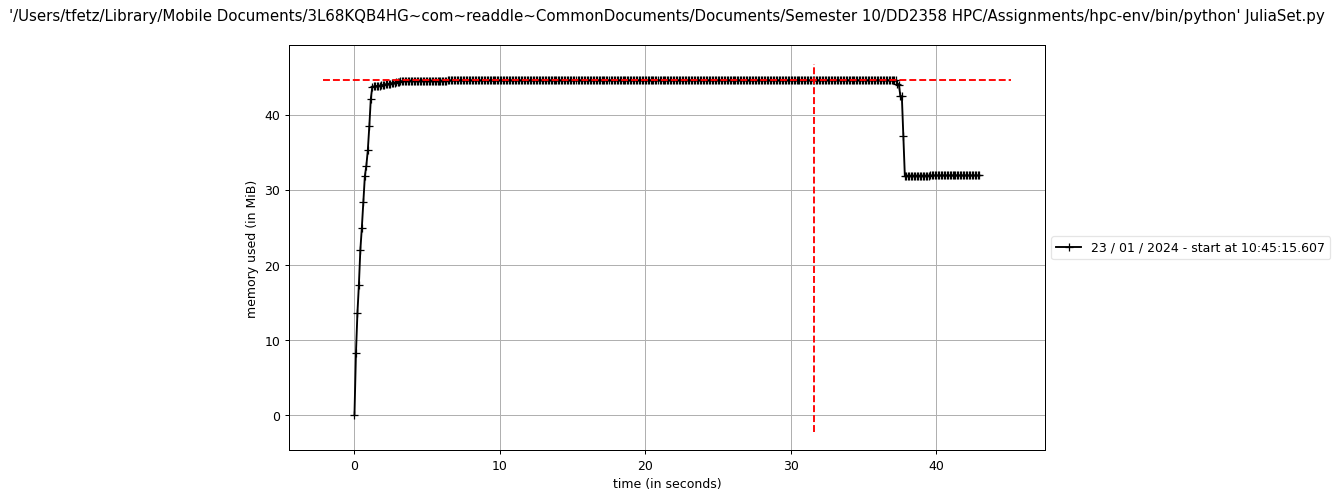

In [45]:
%run -m mprof plot mprofile_20240123104515.dat

# Task 2.1 Profile the diffusion process code
## cProfile

In [46]:
%run -i -m cProfile -o profile_diffusion.stats -s cumulative DiffusionProcess.py

In [ ]:
# %run -i -m kernprof -l JuliaSet.py
%run -i -m line_profiler JuliaSet.py.lprof